# Load data

In [2]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'inheritance_state', 'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'singledel_maternal', 'singledel_paternal'])


In [4]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [6]:
chrom = '22'
family_sizes = [4, 5, 6, 7]
phase_dir = '../sherlock_phased'
data_dir = '../split_gen'

In [8]:
# Pull cytogenetic coordinates
with open('../data/cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [9]:
import numpy as np
clean_file = '%s/clean_indices_%s.txt' % (data_dir, 'X' if chrom.startswith('PAR') else chrom) 
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)
max_index = snp_positions.shape[0]


In [10]:
from collections import defaultdict


# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()

fams = set()
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        num_fams_of_size = 0
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            fams.add(family_key)
            num_fams_of_size += 1
        print('%d families of size %d' % (num_fams_of_size, j))
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key]
            
            if len([x for x in inheritance_state if x is None]) == 0:
                
                doubledel, singledel, nodel = [], [], []
                singledel_mat, singledel_pat = [], []

                # children
                for k, child_id in enumerate(individuals[2:]):
                    mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]

                    if inheritance_state[mat] == 1 and inheritance_state[2+pat] == 1:
                        doubledel.append(child_id)
                    elif inheritance_state[mat] == 1:
                        singledel.append(child_id)
                        singledel_mat.append(child_id)
                    elif inheritance_state[2+pat] == 1:
                        singledel.append(child_id)
                        singledel_pat.append(child_id)
                    else:
                        nodel.append(child_id)

                deletions.append(Deletion(family_key, chrom,
                                              start_pos, end_pos, start_index, end_index, length,
                                              inheritance_state, individuals,
                                              doubledel, singledel, nodel,
                                              singledel_mat, singledel_pat))
        
                
print('Chrom', chrom, 'total families', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', sum([sum(x.inheritance_state[:2]) for x in deletions]), 
      'paternal', sum([sum(x.inheritance_state[2:4]) for x in deletions]))



444 families of size 4
321 families of size 5
51 families of size 6
7 families of size 7
Chrom 22 total families 823
deletions 174041 maternal 188508 paternal 189930


In [11]:
print('Maternal inheritance rate', sum([len(x.singledel_maternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[:2]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[:2]) == 1]))
print('Paternal inheritance rate', sum([len(x.singledel_paternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[2:4]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[2:4]) == 1]))



Maternal inheritance rate 0.5683555461996921
Paternal inheritance rate 0.561338932149786


# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT) and parental differences (PAR) as a baseline.

In [12]:
# Create contingency tables for each comparison
del_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
tdt_conting_t = np.zeros((max_index+1, 2, 2), dtype=int)
par_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
    
for d in deletions:
    del_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
    del_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel if child_id_to_affected[x] != '2'])
    del_conting_t[d.start_index:(d.end_index+1), 2, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 2, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])

    par_conting_t[d.start_index:(d.end_index+1), 2-sum(d.inheritance_state[:2]), 0] += 1
    par_conting_t[d.start_index:(d.end_index+1), 2-sum(d.inheritance_state[2:4]), 1] += 1
    
    if sum(d.inheritance_state[:2]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])
        
    if sum(d.inheritance_state[2:4]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])

        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
    
    
total_affected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] == '2']) for individuals in family_to_individuals.values()])
total_unaffected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] != '2']) for individuals in family_to_individuals.values()])
print('total affected', total_affected, 'total_unaffected', total_unaffected)

total_families = len(family_to_individuals)
print('total families', total_families)


total affected 1703 total_unaffected 387
total families 823


In [13]:
# find indices of changes
del_diff = np.sum(np.abs(del_conting_t[1:, :, :] - del_conting_t[:-1, :, :]), axis=(1, 2))
tdt_diff = np.sum(np.abs(tdt_conting_t[1:, :, :] - tdt_conting_t[:-1, :, :]), axis=(1, 2))
par_diff = np.sum(np.abs(par_conting_t[1:, :, :] - par_conting_t[:-1, :, :]), axis=(1, 2))
indices = np.where((del_diff>0) | (tdt_diff>0) | (par_diff>0))[0]

In [14]:
from scipy.stats import chi2_contingency

# calculate pvalues for every point
del_pvalues = np.ones((max_index+1,))
tdt_pvalues = np.ones((max_index+1,))
par_pvalues = np.ones((max_index+1,))

prev_i = 0
for i in indices:
    # DEL
    dc = del_conting_t[i, :, :]
    dc = dc[np.ix_(np.sum(dc, axis=1)>0, np.sum(dc, axis=0)>0)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
    else:
        del_pvalue = 1
        
    del_pvalues[prev_i:i] = del_pvalue
    #if del_pvalue <= 0.01/indices.shape[0]:
    #    print('DEL', del_pvalue, prev_i, i, int(snp_positions[prev_i]), int(snp_positions[i]))
        
    # TDT
    tc = tdt_conting_t[i, :, :]
    tc = tc[np.ix_(np.sum(tc, axis=1)>0, np.sum(tc, axis=0)>0)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
    else:
        tdt_pvalue = 1
        
    tdt_pvalues[prev_i:i] = tdt_pvalue
    #if tdt_pvalue <= 0.01/indices.shape[0]:
    #    print('TDT', tdt_pvalue, prev_i, i, int(snp_positions[prev_i]), int(snp_positions[i]))

    # PAR
    pc = par_conting_t[i, :, :]
    pc = pc[np.ix_(np.sum(pc, axis=1)>0, np.sum(pc, axis=0)>0)]
    
    if pc.shape[0] > 1 and pc.shape[1] > 1:
        par_pvalue = chi2_contingency(pc, correction=False)[1]
    else:
        par_pvalue = 1
        
    par_pvalues[prev_i:i] = par_pvalue
    #if par_pvalue <= 0.01/indices.shape[0]:
    #    print('PAR', par_pvalue, prev_i, i, int(snp_positions[prev_i]), int(snp_positions[i]))

    prev_i = i

cutoff 0
num peaks 253
num changes 29684


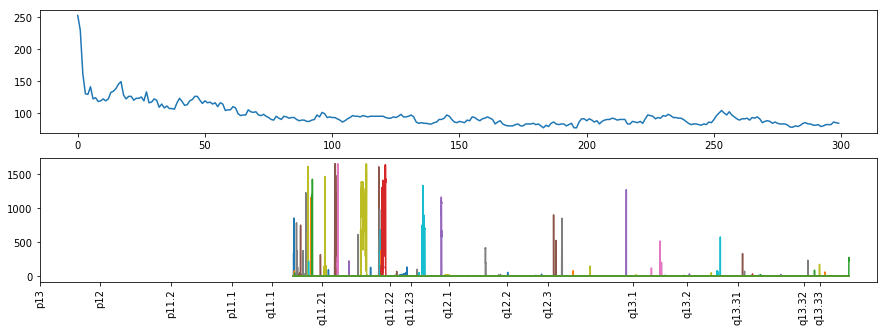

In [15]:
import matplotlib.pyplot as plt

# Identify peaks from PAR
num_people = np.sum(par_conting_t[:, 0:2, :], axis=(1, 2))

# choose cutoff
num_peaks_by_cutoff = [np.where((num_people[:-1] <= x) & (num_people[1:] > x))[0].shape[0] for x in range(300)]
cutoff = max(list(range(300)), key=lambda i: num_peaks_by_cutoff[i])
#cutoff = 5
print('cutoff %d' % cutoff)
    
# define peaks
peak_start_indices = np.where((num_people[:-1] <= cutoff) & (num_people[1:] > cutoff))[0]
peak_end_indices = np.where((num_people[:-1] > cutoff) & (num_people[1:] <= cutoff))[0]
    
# fix first and last
if peak_start_indices[0] > peak_end_indices[0]:
    peak_start_indices = np.insert(peak_start_indices, 0, 0)
if peak_start_indices.shape[0] != peak_end_indices.shape[0]:
    peak_end_indices = np.insert(peak_end_indices, peak_end_indices.shape[0], max_index)
num_peaks = peak_start_indices.shape[0]
print('num peaks %d' % num_peaks)
print('num changes %d' % indices.shape[0])

peaks = list(zip(peak_start_indices, peak_end_indices))

# Take a look
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(num_peaks_by_cutoff)
plt.subplot(2, 1, 2)

for ps, pe in peaks:
    peak_positions = np.zeros((max_index+1,))
    peak_positions[(ps+1):(pe+1)] = num_people[(ps+1):(pe+1)]
    plt.plot(snp_positions[indices], peak_positions[indices])
    
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.show()

In [16]:
#chr 22
#peak_start_poss = np.asarray([32541541, 48644766, 18882415, 20324688])
#peak_end_poss = np.asarray([32552410, 48649449, 18883737, 20325156])

# chr 20
#peak_start_poss = np.asarray([15711541, 24903702, 33814527, 60639874])
#peak_end_poss = np.asarray([15713729, 24905245, 33823832, 60643147])

# chr 18
#peak_start_poss = np.asarray([10101, 5211032, 63533262, 75267238])
#peak_end_poss = np.asarray([11333, 5334883, 63533943, 75268493])

# chr 14
#peak_start_poss = np.asarray([21350372, 68603067, 106061698, 106134889])
#peak_end_poss = np.asarray([21352088, 68606222, 106077445, 106165834])

#num_peaks = len(peak_start_poss)
#peak_start_indices = np.searchsorted(snp_positions, peak_start_poss)
#peak_end_indices = np.searchsorted(snp_positions, peak_end_poss)

In [17]:
num_bases_with_del = np.sum(num_people > 0)
print(num_bases_with_del, num_bases_with_del/snp_positions[-1])

533261 0.0104062035578


In [18]:
# map deletions to peaks
deletion_start_peak_start = np.searchsorted(peak_start_indices, [d.start_index for d in deletions])
deletion_end_peak_end = np.searchsorted(peak_end_indices, [d.end_index for d in deletions])

peak_to_deletions = defaultdict(list)
for d, ds, de in zip(deletions, deletion_start_peak_start, deletion_end_peak_end):
    for i in range(ds-1, min(de+1, peak_start_indices.shape[0])):
        ps, pe = peak_start_indices[i], peak_end_indices[i]
        if (d.start_index >= ps and d.start_index <= pe) or (d.end_index >= ps and d.end_index <= pe) or (d.start_index <= ps and d.end_index >= pe):
            peak_to_deletions[i].append(d)
        

In [19]:

# calculate pvalues for peaks
del_peak_pvalues = np.ones((max_index+1,))
tdt_peak_pvalues = np.ones((max_index+1,))
par_peak_pvalues = np.ones((max_index+1,))

for i in range(num_peaks):
    ds = peak_to_deletions[i]
    doubledel, singledel, nodel = set(), set(), set()
    mom_doubledel, mom_singledel, mom_nodel = set(), set(), set()
    dad_doubledel, dad_singledel, dad_nodel = set(), set(), set()
    trans, notrans = set(), set()
            
    for d in ds:
        # used for DEL
        doubledel.update(d.doubledel)
        singledel.update(d.singledel)
        nodel.update(d.nodel)
        
        
        # used for PAR
        if sum(d.inheritance_state[:2]) == 2:
            mom_doubledel.add(d.individuals[0])
        elif sum(d.inheritance_state[:2]) == 1:
            mom_singledel.add(d.individuals[0])
            
            # TDT
            trans.update(d.doubledel)
            trans.update(d.singledel_maternal)
            notrans.update(d.nodel)
            notrans.update(d.singledel_paternal)
        else:
            mom_nodel.add(d.individuals[0])
            
        if sum(d.inheritance_state[2:4]) == 2:
            dad_doubledel.add(d.individuals[1])
        elif sum(d.inheritance_state[2:4]) == 1:
            dad_singledel.add(d.individuals[1])
            
            # TDT
            trans.update(d.doubledel)
            trans.update(d.singledel_paternal)
            notrans.update(d.nodel)
            notrans.update(d.singledel_maternal)
        else:
            dad_nodel.add(d.individuals[1])
        
    # handle multiple deletions in the same family for this peak
    singledel = singledel - doubledel
    mom_singledel = mom_singledel - mom_doubledel
    dad_singledel = dad_singledel - dad_doubledel
    nodel = nodel - doubledel - singledel
    mom_nodel = mom_nodel - mom_doubledel - mom_singledel
    dad_nodel = dad_nodel - dad_doubledel - dad_singledel
    notrans = notrans - trans
      
    # DEL
    dc = np.asarray([[len([x for x in doubledel if child_id_to_affected[x] == '2']),
                   len([x for x in doubledel if child_id_to_affected[x] != '2'])], 
                   [len([x for x in singledel if child_id_to_affected[x] == '2']),
                   len([x for x in singledel if child_id_to_affected[x] != '2'])], 
                   [len([x for x in nodel if child_id_to_affected[x] == '2']),
                    len([x for x in nodel if child_id_to_affected[x] != '2'])]])
    dc = dc[np.ix_(np.sum(dc, axis=1)>0, np.sum(dc, axis=0)>0)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
    else:
        del_pvalue = 1
        
    del_peak_pvalues[(peak_start_indices[i]+1):(peak_end_indices[i]+1)] = del_pvalue
       
    # TDT
    tc = np.asarray([[len([x for x in trans if child_id_to_affected[x] == '2']),
                   len([x for x in trans if child_id_to_affected[x] != '2'])],
                  [len([x for x in notrans if child_id_to_affected[x] == '2']),
                   len([x for x in notrans if child_id_to_affected[x] != '2'])]])
    tc = tc[np.ix_(np.sum(tc, axis=1)>0, np.sum(tc, axis=0)>0)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
    else:
        tdt_pvalue = 1
        
    tdt_peak_pvalues[(peak_start_indices[i]+1):(peak_end_indices[i]+1)] = tdt_pvalue
        
    # PAR
    pc = np.asarray([[len(mom_doubledel), len(dad_doubledel)],
                  [len(mom_singledel), len(dad_singledel)],
                  [len(mom_nodel), len(dad_nodel)]])
    pc = pc[np.ix_(np.sum(pc, axis=1)>0, np.sum(pc, axis=0)>0)]
        
    if pc.shape[0] > 1 and pc.shape[1] > 1:
        par_pvalue = chi2_contingency(pc, correction=False)[1]
    else:
        par_pvalue = 1
    
    par_peak_pvalues[(peak_start_indices[i]+1):(peak_end_indices[i]+1)] = par_pvalue

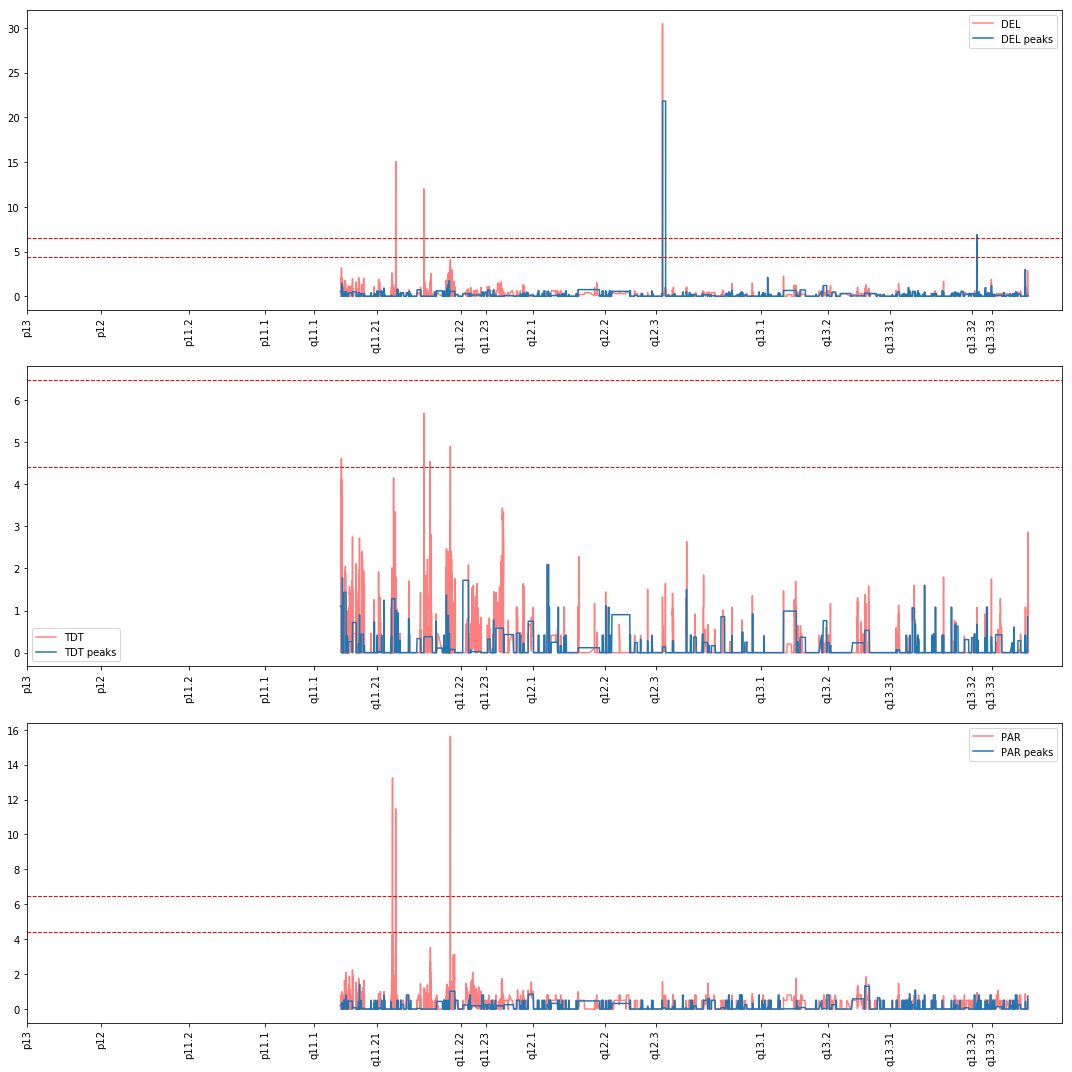

In [20]:
# plot pvalues
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)                                         
plt.plot(snp_positions[indices], -np.log10(del_pvalues[indices]), alpha=0.5, label='DEL', color='red')
plt.plot(snp_positions[indices], -np.log10(del_peak_pvalues[indices]), label='DEL peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.subplot(3, 1, 2)            
plt.plot(snp_positions[indices], -np.log10(tdt_pvalues[indices]), alpha=0.5, label='TDT', color='red')
plt.plot(snp_positions[indices], -np.log10(tdt_peak_pvalues[indices]), label='TDT peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.subplot(3, 1, 3) 
plt.plot(snp_positions[indices], -np.log10(par_pvalues[indices]), alpha=0.5, label='PAR', color='red')
plt.plot(snp_positions[indices], -np.log10(par_peak_pvalues[indices]), label='PAR peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.tight_layout()
plt.show()

# Let's consider missing deletions
We won't be able to detect a deletion if it isn't inherited. So what fraction of the genome isn't inherited?

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:4544: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


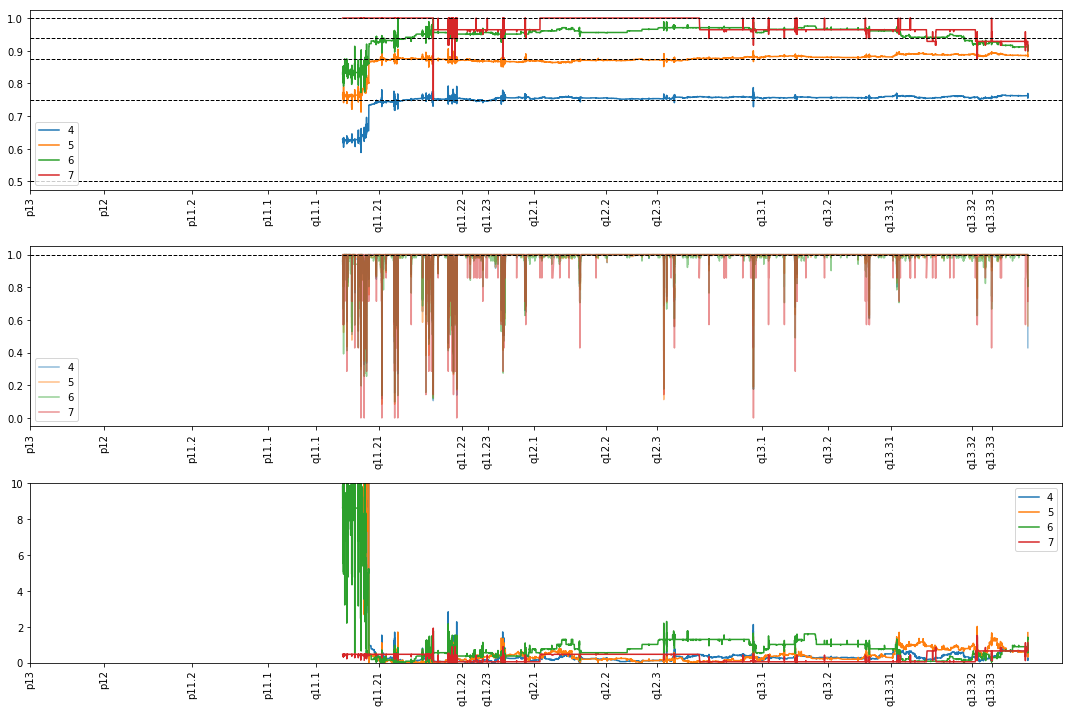

In [21]:
from scipy.stats import chisquare

plt.figure(figsize=(15, 10))
inh_ps = [0]*(max(family_sizes)+1)
for j in family_sizes:
    inherited = np.zeros((max_index+1,), dtype=int)
    not_inherited = np.zeros((max_index+1,), dtype=int)

    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            
            if len([x for x in inheritance_state if x is None]) == 0:
                
                m1_inh, m2_inh, p1_inh, p2_inh = 0, 0, 0, 0
                for k, s in enumerate(inheritance_state[4:]):
                    if k % 2 == 0:
                        m1_inh += (s==0)
                        m2_inh += (s==1)
                    else:
                        p1_inh += (s==0)
                        p2_inh += (s==1)
                        
                num_inherited = (m1_inh>0) + (m2_inh>0) + (p1_inh>0) + (p2_inh>0)
                inherited[start_index:(end_index+1)] += num_inherited
                not_inherited[start_index:(end_index+1)] += 4 - num_inherited

        plt.subplot(3, 1, 1)
        plt.plot(snp_positions[indices], (inherited/(inherited+not_inherited))[indices], label=str(j))
        plt.subplot(3, 1, 2)
        plt.plot(snp_positions[indices], (inherited[indices]+not_inherited[indices])/np.max(inherited+not_inherited), label=str(j), alpha=0.5)
        
        # calc pvalues
        inh_ps[j] = np.ones((max_index+1,))
        for i in indices:
            p_not_inherited = pow(0.5, j-2)
            inh, notinh = inherited[i], not_inherited[i]
            total = inh+notinh
            inh_ps[j][i] = chisquare([inh, notinh], [total*(1-p_not_inherited), total*p_not_inherited])[1]
        plt.subplot(3, 1, 3)
        plt.plot(snp_positions[indices], -np.log10(inh_ps[j][indices]), label=str(j))
        
plt.subplot(3, 1, 1)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(3, 1, 2)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.legend()

plt.subplot(3, 1, 3)
plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.ylim(0, 10)
plt.legend()

plt.tight_layout()
plt.show()

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


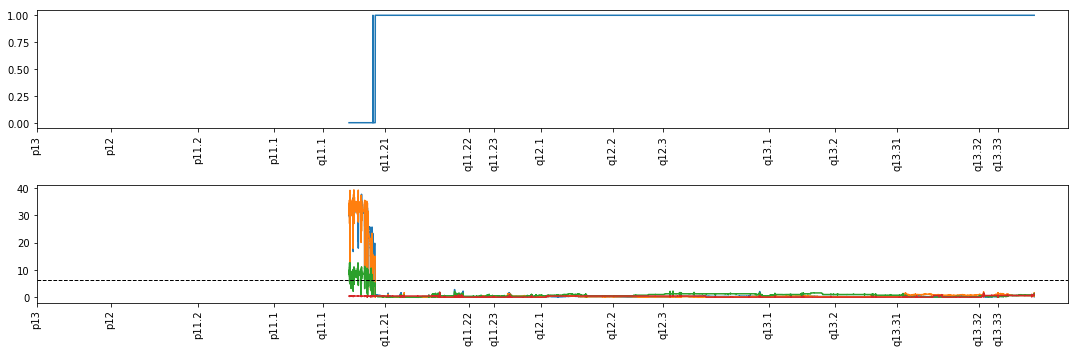

In [22]:
plt.figure(figsize=(15, 5))
# only look at regions where inheritance rate is close to expected
ok_indices = np.ones((max_index+1,), dtype=bool)
plt.subplot(2, 1, 2)
for j in family_sizes:
    ok_indices[np.where(-np.log10(inh_ps[j]) > -np.log10(0.01/indices.shape[0]))[0]] = 0
    plt.plot(snp_positions[indices], -np.log10(inh_ps[j][indices]))
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='black')

plt.subplot(2, 1, 1)
plt.plot(snp_positions[indices], ok_indices[indices])
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.tight_layout()
plt.show()

In [23]:
print('Chrom', chrom)

# DEL hist  
hit_start_indices = np.where((del_peak_pvalues[:-1] > 0.01/num_peaks) & (del_peak_pvalues[1:] <= 0.01/num_peaks))[0]
hit_end_indices = np.where((del_peak_pvalues[:-1] <= 0.01/num_peaks) & (del_peak_pvalues[1:] > 0.01/num_peaks))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('DELpeak', int(snp_positions[hit_end])-int(snp_positions[hit_start+1]), hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end]), xticklabels[cyto])

del_np_pvalues = del_pvalues
del_np_pvalues[del_peak_pvalues <= 0.01/num_peaks] = 1
hit_start_indices = np.where((del_np_pvalues[:-1] > 0.01/indices.shape[0]) & (del_np_pvalues[1:] <= 0.01/indices.shape[0]))[0]
hit_end_indices = np.where((del_np_pvalues[:-1] <= 0.01/indices.shape[0]) & (del_np_pvalues[1:] > 0.01/indices.shape[0]))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if (hit_end-hit_start > 100) and (np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start) and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('DEL', int(snp_positions[hit_end+1])-int(snp_positions[hit_start+1]), hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]), xticklabels[cyto])

# TDT hist
hit_start_indices = np.where((tdt_peak_pvalues[:-1] > 0.01/num_peaks) & (tdt_peak_pvalues[1:] <= 0.01/num_peaks))[0]
hit_end_indices = np.where((tdt_peak_pvalues[:-1] <= 0.01/num_peaks) & (tdt_peak_pvalues[1:] > 0.01/num_peaks))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('TDTpeak', int(snp_positions[hit_end+1])-int(snp_positions[hit_start+1]), hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end]), xticklabels[cyto])

tdt_np_pvalues = tdt_pvalues
tdt_np_pvalues[tdt_peak_pvalues <= 0.01/num_peaks] = 1
hit_start_indices = np.where((tdt_np_pvalues[:-1] > 0.01/indices.shape[0]) & (tdt_np_pvalues[1:] <= 0.01/indices.shape[0]))[0]
hit_end_indices = np.where((tdt_np_pvalues[:-1] <= 0.01/indices.shape[0]) & (tdt_np_pvalues[1:] > 0.01/indices.shape[0]))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if (hit_end-hit_start > 100) and np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('TDT', int(snp_positions[hit_end+1])-int(snp_positions[hit_start+1]), hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]), xticklabels[cyto])
        

# PAR hist
#hit_start_indices = np.where((par_pvalues[:-1] > 0.01/indices.shape[0]) & (par_pvalues[1:] <= 0.01/indices.shape[0]))[0]
#hit_end_indices = np.where((par_pvalues[:-1] <= 0.01/indices.shape[0]) & (par_pvalues[1:] > 0.01/indices.shape[0]))[0]

#for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
#    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start:
#        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
#        print('PAR', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]), xticklabels[cyto])
        
#hit_start_indices = np.where((par_peak_pvalues[:-1] > 0.01/num_peaks) & (par_peak_pvalues[1:] <= 0.01/num_peaks))[0]
#hit_end_indices = np.where((par_peak_pvalues[:-1] <= 0.01/num_peaks) & (par_peak_pvalues[1:] > 0.01/num_peaks))[0]
#
#for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
#    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start:
#        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
#        print('PAR peak', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end]), xticklabels[cyto])
           

Chrom 22
DELpeak 160618 477968 482557 32541541 32702159 q12.3
DELpeak 6960 919387 919631 48644766 48651726 q13.32


# Check for outliers

In [85]:
next_state = [0, 0, 0, 0]
starts = [max_index+1, max_index+1, max_index+1, max_index+1]
del_start = np.zeros((max_index,))
del_end = np.zeros((max_index,))
del_intervals = []
prev_key = None
for j in family_sizes:      
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1
            
            if len([x for x in inheritance_state[:4] if x is None]) == 0:
                if prev_key != family_key:
                    next_state = inheritance_state[:4]
                    starts = [max_index+1, max_index+1, max_index+1, max_index+1]
                    prev_key = family_key
                
                for i in range(4):
                    if inheritance_state[i] == 0 and next_state[i] == 1:
                        del_start[end_index:starts[i]] += 1
                        del_intervals.append(snp_positions[starts[i]]-snp_positions[end_index])
                       # print('start', end_index, starts[i], starts[i]-end_index)

                    elif inheritance_state[i] == 1 and next_state[i] == 0:
                        del_end[end_index:starts[i]] += 1
                        del_intervals.append(snp_positions[starts[i]]-snp_positions[end_index])
                        #print('end', end_index, starts[i], starts[i]-end_index)

                    starts[i] = start_index
                    next_state[i] = inheritance_state[i]

196.0
min length 1 max length 3020154 num 555166


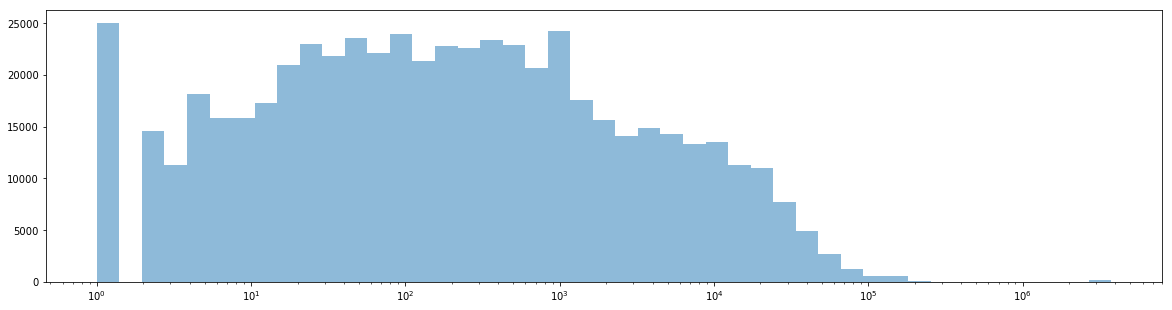

In [88]:
import math

print(np.median([x for x in del_intervals if x != 1]))

plt.figure(figsize=(20, 5))
base = 1.4
max_length = max(del_intervals) 
min_length = min(del_intervals) 
print('min length', min_length, 'max length', max_length, 'num', len(del_intervals))
plt.hist(del_intervals, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.gca().set_xscale("log")
plt.show()

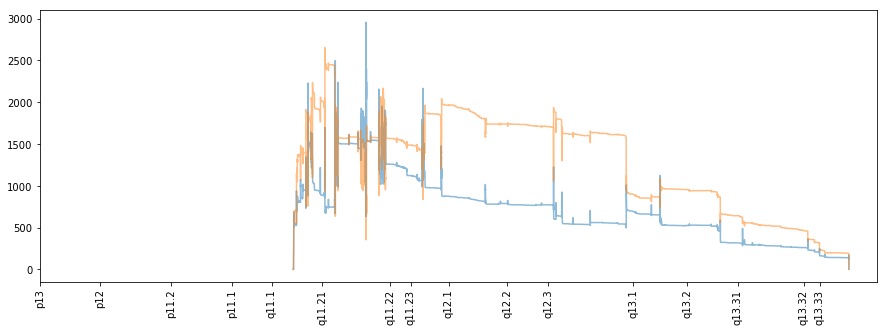

In [55]:
plt.figure(figsize=(15, 5))
plt.plot(snp_positions, del_start, alpha=0.5)
plt.plot(snp_positions, del_end, alpha=0.5)
plt.xticks(xticks, xticklabels, rotation='vertical')

plt.show()

outliers 0
[]


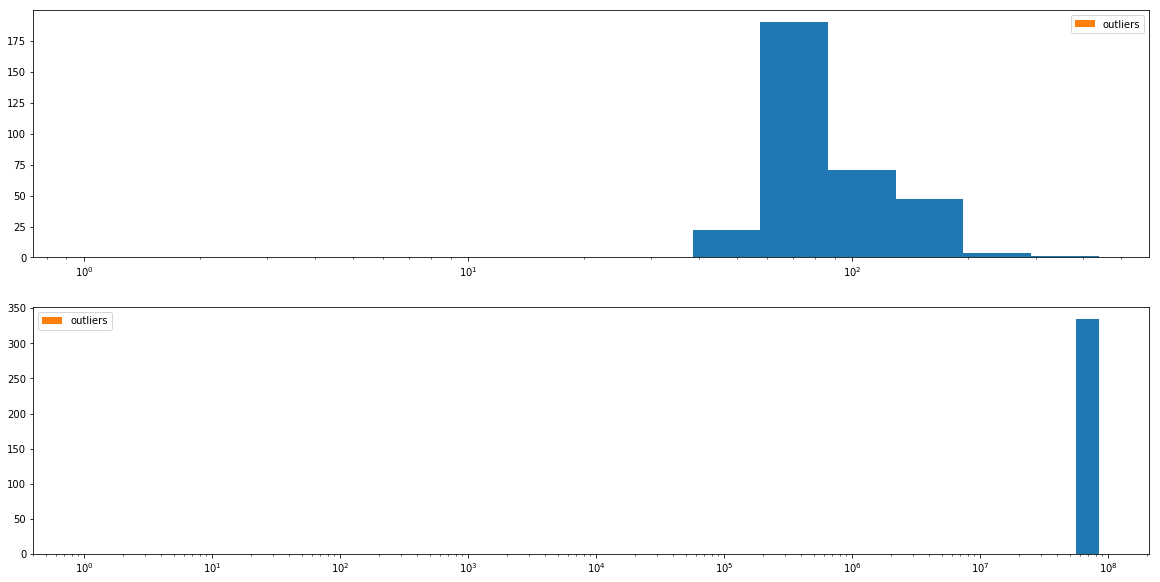

In [323]:
import math

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# deletions per family
plt.figure(figsize=(20, 10))

family_to_num_deletions = defaultdict(int)
family_to_nucleo_deleted = defaultdict(int)

for d in deletions:
    family_to_num_deletions[d.family] += 1
    family_to_nucleo_deleted[d.family] += d.length
    
outliers = [f for f in family_to_num_deletions.keys() if family_to_num_deletions[f] > 10000]
print('outliers', len(outliers))
print([(f, len(family_to_individuals[f])) for f in outliers])

base = 1.5

plt.subplot(2, 1, 1)
max_length = max(family_to_num_deletions.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_num_deletions.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_num_deletions.items() if f in outliers], bins=bins, label='outliers')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(2, 1, 2)
max_length = max(family_to_nucleo_deleted.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f in outliers], bins=bins, label='outliers')

plt.gca().set_xscale("log")
plt.legend()

#ax3 = plt.subplot(3, 1, 3)
#min_family = min(family_to_num_deletions.items(), key=lambda x:x[1])[0]
#max_family = max(family_to_num_deletions.items(), key=lambda x:x[1])[0]

#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==min_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='blue')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)
#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==max_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='red')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)

#plt.plot(sum([[d.start_pos, d.end_pos] for d in min_family_dels]), sum([[]]))
#plt.legend()
plt.show()

# Distribution of deletions

191044256
min length 9 max length 4092328 num 288441 num/family 331.9228998849252


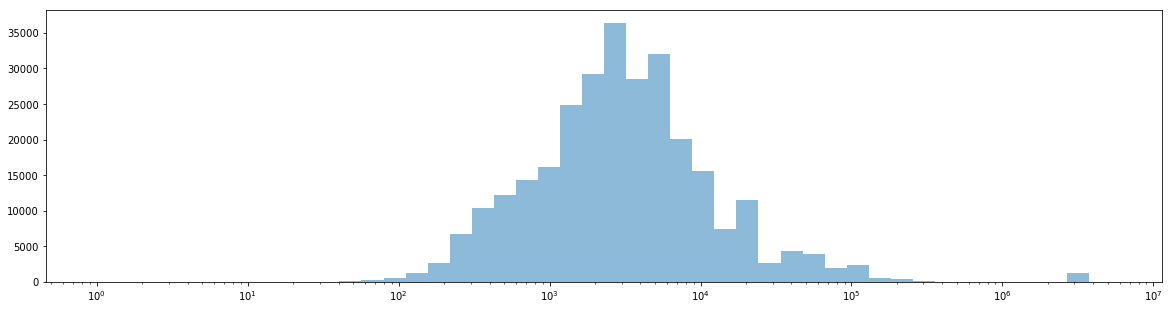

In [92]:
import math

d_length = [0, 0, 0, 0]
d_intervals = []
for j in family_sizes:
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            inheritance_state = [None if x == '*' else int(x) for x in pieces[1:(1+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(1+(j*2)):(5+(j*2))]]
            length = end_pos - start_pos + 1

            for i in range(4):
                if inheritance_state[i] == 1:
                    d_length[i] += length
                elif d_length[i] != 0:
                    d_intervals.append(d_length[i])
                    d_length[i] = 0
for i in range(4):
    if d_length[i] != 0:
        d_intervals.append(d_length[i])
    

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max(d_intervals) 
min_length = min(d_intervals) 
print(snp_positions[-1])
print('min length', min_length, 'max length', max_length, 'num', len(d_intervals), 'num/family', len(d_intervals)/len(family_to_individuals))
plt.hist(d_intervals, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)
plt.gca().set_xscale("log")
plt.show()

min length 0 max length 683805


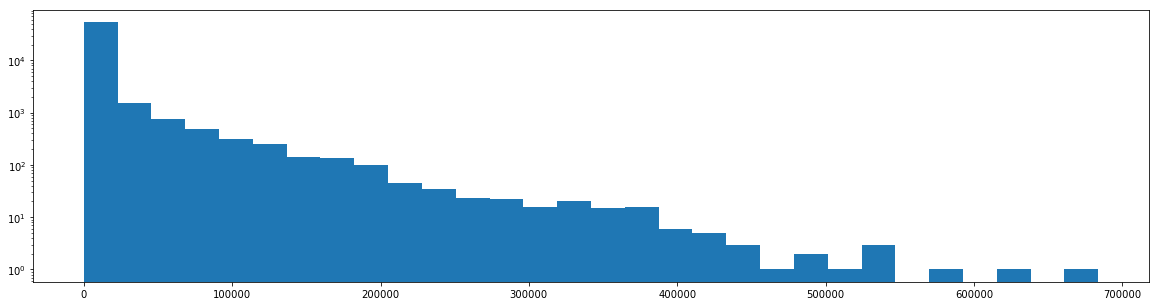

In [84]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.end_index-d.start_index for d in deletions]) 
min_length = min([d.end_index-d.start_index for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.end_index-d.start_index for d in deletions], bins=30, log=True)#, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
#plt.gca().set_xscale("log")
plt.show()

# Investigate deletions in cytogenetic regions

In [24]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print(m, n)

4610 1096535
4610 1003938


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


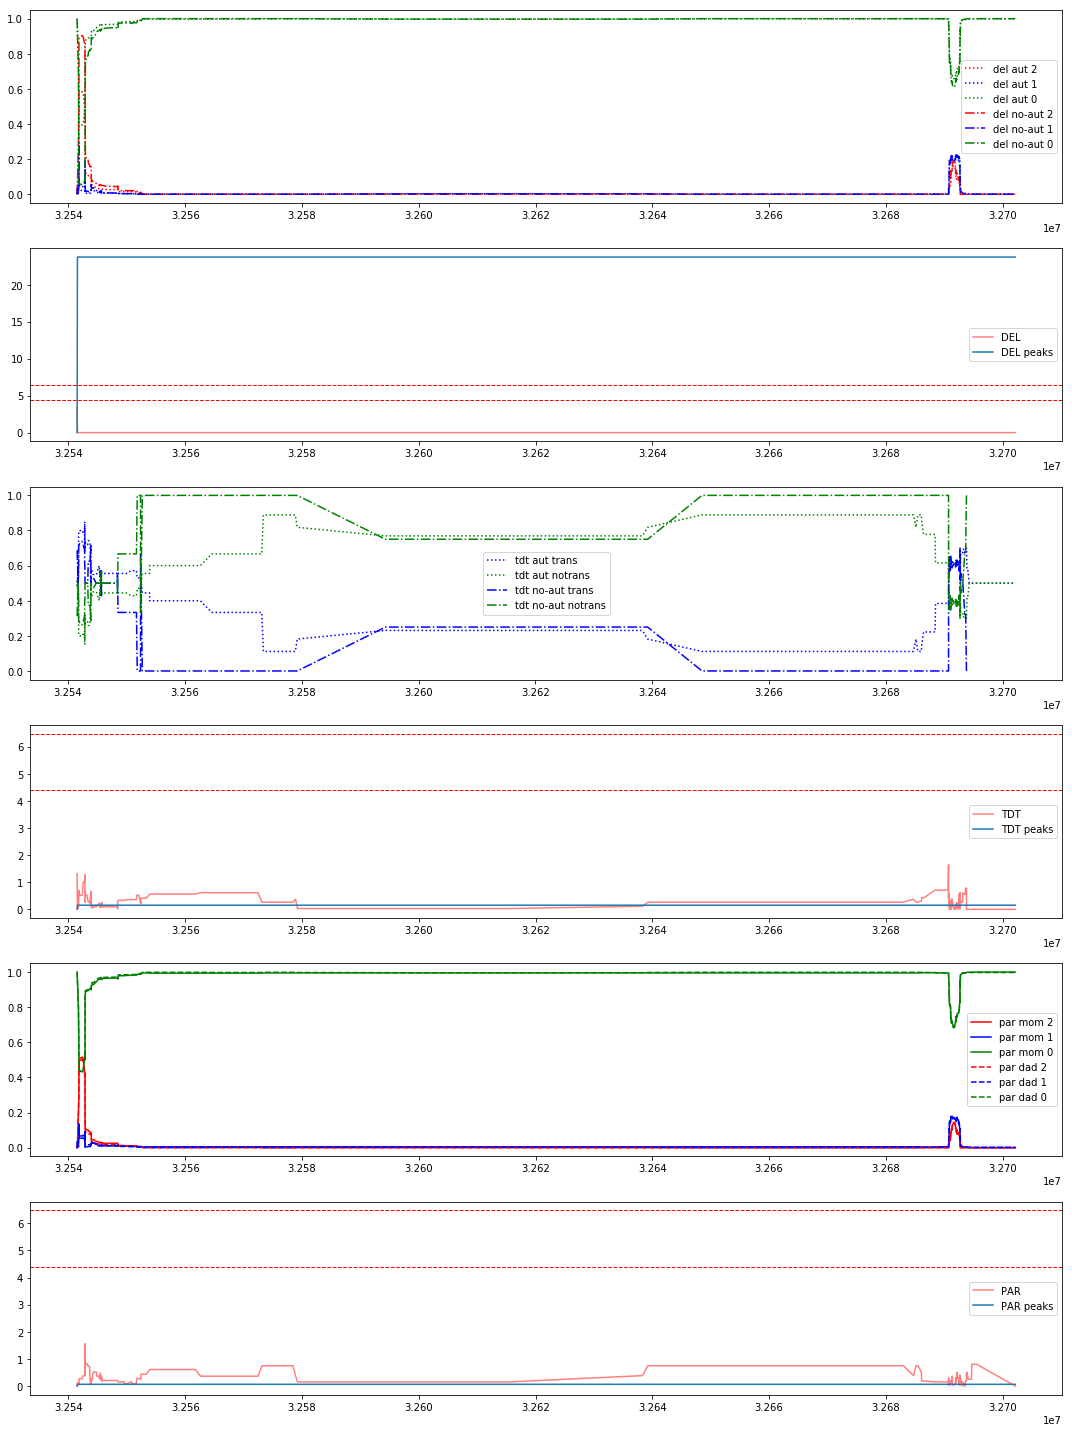

In [30]:
#start, end = 23500000, 25900000
#start, end = 24340000, 24400000

#region = 'q12.3'
#region_index = xticklabels.index(region)
#start, end = xticks[region_index], snp_positions[indices][-1] if region_index == len(xticks)-1 else xticks[region_index+1]
#start, end = 18718200, 18719700
#start, end = 18715000, 18723000
#start, end = 18878647, 18883675
#start, end = 20657800, 20658000
#start, end = 20659158, 20659224
#start, end = 940287, 940304

#start, end = 24340000, 24400000
#region_indices = [i for i in indices if snp_positions[i]>= start and snp_positions[i] <= end]
#start, end = 940280, 940310
#start, end = 2075531, 2075555
start, end = 477968, 482557
region_indices = [i for i in indices if i >= start and i <= end]
plt.figure(figsize=(15, 20))

plt.subplot(6, 1, 1)
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 0, 0]/np.sum(del_conting_t[region_indices, :, 0], axis=1), label='del aut 2', color='red', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 1, 0]/np.sum(del_conting_t[region_indices, :, 0], axis=1), label='del aut 1', color='blue', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 2, 0]/np.sum(del_conting_t[region_indices, :, 0], axis=1), label='del aut 0', color='green', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 0, 1]/np.sum(del_conting_t[region_indices, :, 1], axis=1), label='del no-aut 2', color='red', linestyle='-.')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 1, 1]/np.sum(del_conting_t[region_indices, :, 1], axis=1), label='del no-aut 1', color='blue', linestyle='-.')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 2, 1]/np.sum(del_conting_t[region_indices, :, 1], axis=1), label='del no-aut 0', color='green', linestyle='-.')
plt.legend()

plt.subplot(6, 1, 2)                                         
plt.plot(snp_positions[region_indices], -np.log10(del_pvalues[region_indices]), alpha=0.5, label='DEL', color='red')
plt.plot(snp_positions[region_indices], -np.log10(del_peak_pvalues[region_indices]), label='DEL peaks')

plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(snp_positions[region_indices], tdt_conting_t[region_indices, 0, 0]/np.sum(tdt_conting_t[region_indices, :, 0], axis=1), label='tdt aut trans', color='blue', linestyle=':')
plt.plot(snp_positions[region_indices], tdt_conting_t[region_indices, 1, 0]/np.sum(tdt_conting_t[region_indices, :, 0], axis=1), label='tdt aut notrans', color='green', linestyle=':')
plt.plot(snp_positions[region_indices], tdt_conting_t[region_indices, 0, 1]/np.sum(tdt_conting_t[region_indices, :, 1], axis=1), label='tdt no-aut trans', color='blue', linestyle='-.')
plt.plot(snp_positions[region_indices], tdt_conting_t[region_indices, 1, 1]/np.sum(tdt_conting_t[region_indices, :, 1], axis=1), label='tdt no-aut notrans', color='green', linestyle='-.')
plt.legend()

plt.subplot(6, 1, 4)            
plt.plot(snp_positions[region_indices], -np.log10(tdt_pvalues[region_indices]), alpha=0.5, label='TDT', color='red')
plt.plot(snp_positions[region_indices], -np.log10(tdt_peak_pvalues[region_indices]), label='TDT peaks')

plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()

plt.subplot(6, 1, 5) 
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 0, 0]/np.sum(par_conting_t[region_indices, :, 0], axis=1), label='par mom 2', color='red')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 1, 0]/np.sum(par_conting_t[region_indices, :, 0], axis=1), label='par mom 1', color='blue')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 2, 0]/np.sum(par_conting_t[region_indices, :, 0], axis=1), label='par mom 0', color='green')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 0, 1]/np.sum(par_conting_t[region_indices, :, 1], axis=1), label='par dad 2', color='red', linestyle='--')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 1, 1]/np.sum(par_conting_t[region_indices, :, 1], axis=1), label='par dad 1', color='blue', linestyle='--')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 2, 1]/np.sum(par_conting_t[region_indices, :, 1], axis=1), label='par dad 0', color='green', linestyle='--')
plt.legend()


plt.subplot(6, 1, 6) 
plt.plot(snp_positions[region_indices], -np.log10(par_pvalues[region_indices]), alpha=0.5, label='PAR', color='red')
plt.plot(snp_positions[region_indices], -np.log10(par_peak_pvalues[region_indices]), label='PAR peaks')

plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.tight_layout()
plt.show()

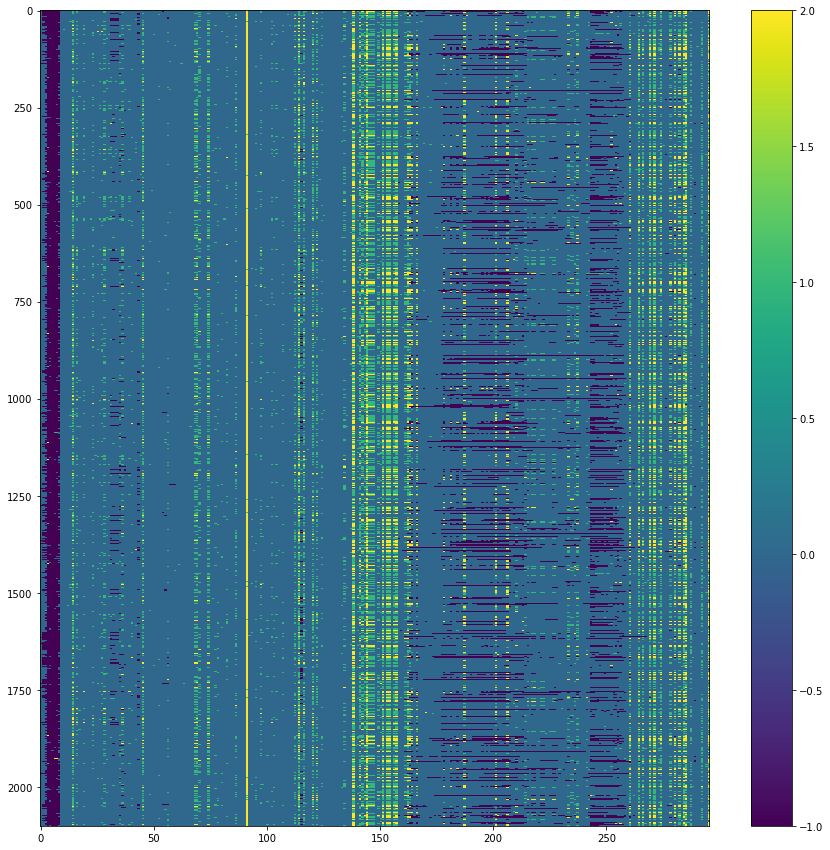

In [36]:
affected_child_indices, unaffected_child_indices = [], []
male_indices, female_indices = [], []

# pull indices of sample_ids
sample_file = 'split_gen/chr.%s.gen.samples.txt' % ('X' if chrom.startswith('PAR') else chrom)
with open(sample_file, 'r') as f:
    sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

for fkey, individuals in family_to_individuals.items():
    for indid in individuals[2:]:
        if child_id_to_affected[indid] == '2':
            affected_child_indices.append(sample_id_to_index[indid])
        else:
            unaffected_child_indices.append(sample_id_to_index[indid])
        
        if child_id_to_sex[indid] == '1':
            male_indices.append(sample_id_to_index[indid])
        else:
            female_indices.append(sample_id_to_index[indid])
                        
region = whole_chrom[:, region_indices].A
plt.figure(figsize=(15, 15))
plt.imshow(region[affected_child_indices + unaffected_child_indices, :], aspect='auto')
plt.colorbar()
plt.show()

# Quick Missing Value Analysis

In [651]:
mom_missing = np.sum(whole_chrom[mom_indices, :]==-1, axis=0)
mom_het = np.sum(whole_chrom[mom_indices, :]==1, axis=0)
mom_homalt = np.sum(whole_chrom[mom_indices, :]==2, axis=0)

dad_missing = np.sum(whole_chrom[dad_indices, :]==-1, axis=0)
dad_het = np.sum(whole_chrom[dad_indices, :]==1, axis=0)
dad_homalt = np.sum(whole_chrom[dad_indices, :]==2, axis=0)

aff_missing = np.sum(whole_chrom[affected_child_indices, :]==-1, axis=0)
aff_het = np.sum(whole_chrom[affected_child_indices, :]==1, axis=0)
aff_homalt = np.sum(whole_chrom[affected_child_indices, :]==2, axis=0)

unaff_missing = np.sum(whole_chrom[unaffected_child_indices, :]==-1, axis=0)
unaff_het = np.sum(whole_chrom[unaffected_child_indices, :]==1, axis=0)
unaff_homalt = np.sum(whole_chrom[unaffected_child_indices, :]==2, axis=0)

In [673]:
male_missing = np.sum(whole_chrom[male_indices, :]==-1, axis=0)
male_het = np.sum(whole_chrom[male_indices, :]==1, axis=0)
male_homalt = np.sum(whole_chrom[male_indices, :]==2, axis=0)

female_missing = np.sum(whole_chrom[female_indices, :]==-1, axis=0)
female_het = np.sum(whole_chrom[female_indices, :]==1, axis=0)
female_homalt = np.sum(whole_chrom[female_indices, :]==2, axis=0)

total_male = len(male_indices)
total_female = len(female_indices)
print(len(female_child_indices), len(male_child_indices))

494 1345


In [636]:
trans_to_pvalue = dict()

mom_v_dad_missing = np.ones((whole_chrom.shape[1],))
mom_v_dad_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (mom_missing[0, i], dad_missing[0, i], total_families-mom_missing[0, i], total_families-dad_missing[0, i])
    if mom_missing[0, i]>0 or dad_missing[0, i]>0:
        if t not in trans_to_pvalue:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        mom_v_dad_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_families-mom_missing[0, i]-mom_het[0, i]-mom_homalt[0, i], 
         total_families-dad_missing[0, i]-dad_het[0, i]-dad_homalt[0, i], 
         mom_het[0, i], dad_het[0, i], 
         mom_homalt[0, i], dad_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        mom_v_dad_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


6.9810208381
(0, 26, 0, 1, 0, 0)
(0, 23, 0, 0, 0, 1)
(0, 28, 0, 0, 0, 27)
(0, 26, 0, 0, 0, 7)
(0, 23, 0, 1, 0, 0)
(0, 25, 0, 4, 0, 0)
(0, 23, 0, 2, 0, 0)
(0, 23, 0, 2, 0, 1)
7.91754961945


In [641]:
trans_to_pvalue = dict()

aff_v_unaff_missing = np.ones((whole_chrom.shape[1],))
aff_v_unaff_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (aff_missing[0, i], unaff_missing[0, i], total_affected-aff_missing[0, i], total_unaffected-unaff_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValuError:
            print(t)
    if t in trans_to_pvalue:
        aff_v_unaff_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_affected-aff_missing[0, i]-aff_het[0, i]-aff_homalt[0, i], 
         total_unaffected-unaff_missing[0, i]-unaff_het[0, i]-unaff_homalt[0, i], 
         aff_het[0, i], unaff_het[0, i], 
         aff_homalt[0, i], unaff_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        aff_v_unaff_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


6.94297483243
(1, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 1, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(1, 0, 2, 0, 0, 0)
(0, 0, 1, 0, 1, 0)
(2, 0, 0, 0, 3, 0)
(3, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 2, 0)
(2, 0, 4, 0, 1, 0)
(2, 0, 3, 0, 1, 0)
(5, 0, 1, 0, 0, 0)
(9, 0, 1, 0, 0, 0)
(5, 0, 0, 0, 1, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(7, 0, 0, 0, 3, 0)
(1, 0, 0, 0, 3, 0)
(1, 0, 2, 0, 3, 0)
(1, 0, 3, 0, 0, 0)
(1, 0, 1, 0, 0, 0)
7.87313393717


In [736]:
trans_to_pvalue = dict()

male_v_female_missing = np.ones((whole_chrom.shape[1],))
male_v_female_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (male_missing[0, i], female_missing[0, i], total_male-male_missing[0, i], total_female-female_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_male-male_missing[0, i]-male_het[0, i]-male_homalt[0, i], 
         total_female-female_missing[0, i]-female_het[0, i]-female_homalt[0, i], 
         male_het[0, i], female_het[0, i], 
         male_homalt[0, i], female_homalt[0, i],
         male_missing[0, i], female_missing[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]], [t[6], t[7]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


7.02576040739
7.93619192366


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


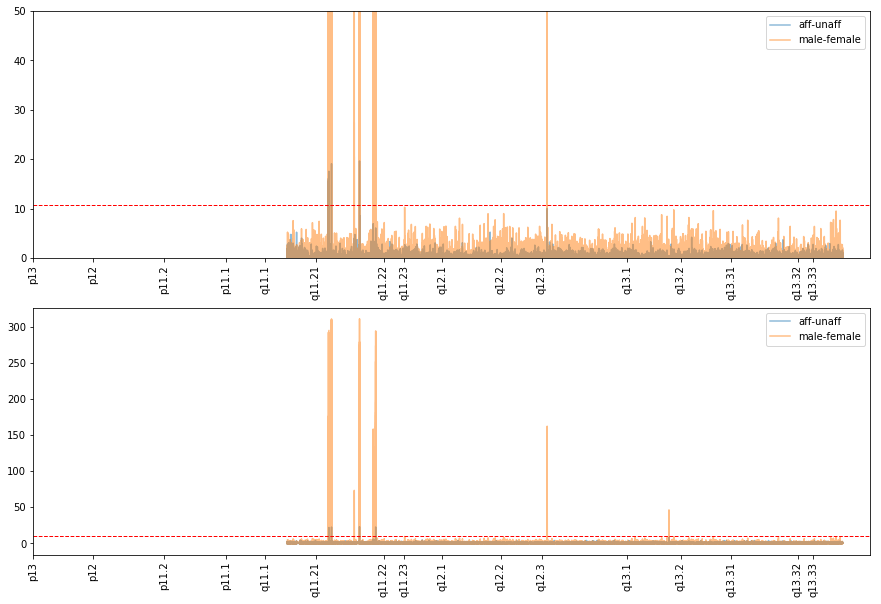

In [739]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
#plt.plot(snp_positions_all, -np.log10(mom_v_dad_missing), alpha=0.5, label='mom-dad')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_missing), alpha=0.5, label='aff-unaff')
plt.plot(snp_positions_all, -np.log10(male_v_female_missing), alpha=0.5, label='male-female')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(2, 1, 2)
#plt.plot(snp_positions_all, -np.log10(mom_v_dad_gen), alpha=0.5, label='mom-dad')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_gen), alpha=0.5, label='aff-unaff')
plt.plot(snp_positions_all, -np.log10(male_v_female_gen), alpha=0.5, label='male-female')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
#plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.show()

In [781]:
is_sig = np.where(-np.log10(male_v_female_gen[1:])>=10)[0]
print(is_sig[:10])

[96294 96296 96301 96304 96308 96314 96316 96319 96321 96325]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [ ]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load dp
chrom = 22
dp_files = sorted([f for f in listdir('split_dp') if ('chr.%d' % chrom) in f and 'dp.npz' in f])
whole_dp = sparse.hstack([sparse.load_npz('split_dp/%s' % dp_file) for dp_file in dp_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_dp/chr.%d.dp.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_dp = whole_dp[:, snp_indices].A
print(whole_chrom.shape, whole_dp.shape)

In [ ]:
whole_dp[whole_dp == 0] = 20

In [ ]:
region_dp = whole_dp[:, is_sig].A

plt.figure(figsize=(15, 20))
plt.subplot(2, 1, 1)
plt.imshow(whole_chrom[female_indices+male_indices, 96200:96500].A, aspect='auto')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(whole_dp[female_indices+male_indices, 96200:96500].A, aspect='auto')
plt.colorbar()

plt.show()